In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

1. IMPORTS & SEEDING

In [37]:
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
def seed_everything(seed=42):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

2. Looking At The Data

In [39]:
train_df = pd.read_csv('../data/train.csv')
print(f"Train data loaded: {train_df.shape}")
print(f"   - Unique stocks: {train_df['stock_id'].nunique()}")
print(f"   - Unique time_ids: {train_df['time_id'].nunique()}")
print(f"   - Target range: [{train_df['target'].min():.6f}, {train_df['target'].max():.6f}]")

# sequential split by time_id
print("\n Creating sequential train/validation split...")
unique_time_ids = sorted(train_df['time_id'].unique())
split_point = int(0.8 * len(unique_time_ids))

train_time_ids = unique_time_ids[:split_point]
valid_time_ids = unique_time_ids[split_point:]

train_data = train_df[train_df['time_id'].isin(train_time_ids)].copy()
valid_data = train_df[train_df['time_id'].isin(valid_time_ids)].copy()

print(f"Sequential split completed:")
print(f"   - Train: {len(train_data)} rows ({len(train_time_ids)} time_ids)")
print(f"   - Valid: {len(valid_data)} rows ({len(valid_time_ids)} time_ids)")
print(f"   - Train time_id range: {min(train_time_ids)} to {max(train_time_ids)}")
print(f"   - Valid time_id range: {min(valid_time_ids)} to {max(valid_time_ids)}")


Train data loaded: (428932, 3)
   - Unique stocks: 112
   - Unique time_ids: 3830
   - Target range: [0.000105, 0.070321]

 Creating sequential train/validation split...
Sequential split completed:
   - Train: 343144 rows (3064 time_ids)
   - Valid: 85788 rows (766 time_ids)
   - Train time_id range: 5 to 25680
   - Valid time_id range: 25683 to 32767


In [40]:
import pandas as pd

book_train_path = '../data/book_train.parquet'
trade_train_path = '../data/trade_train.parquet'

sample_book = pd.read_parquet(f'{book_train_path}/stock_id=0')
sample_trade = pd.read_parquet(f'{trade_train_path}/stock_id=0')

print(f"Sample book data (stock_id=0): {sample_book.shape}")
print(f"   Columns: {list(sample_book.columns)}")
print(f"Sample trade data (stock_id=0): {sample_trade.shape}")
print(f"   Columns: {list(sample_trade.columns)}")

Sample book data (stock_id=0): (917553, 10)
   Columns: ['time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']
Sample trade data (stock_id=0): (123443, 5)
   Columns: ['time_id', 'seconds_in_bucket', 'price', 'size', 'order_count']


In [41]:
book_train_path = '../data/book_train.parquet'
trade_train_path = '../data/trade_train.parquet'

sample_book = pd.read_parquet(f'{book_train_path}/stock_id=0')
sample_trade = pd.read_parquet(f'{trade_train_path}/stock_id=0')

print(f"Sample book data (stock_id=0): {sample_book.shape}")
print(f"   Columns: {list(sample_book.columns)}")
print(f"Sample trade data (stock_id=0): {sample_trade.shape}")
print(f"   Columns: {list(sample_trade.columns)}")

Sample book data (stock_id=0): (917553, 10)
   Columns: ['time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']
Sample trade data (stock_id=0): (123443, 5)
   Columns: ['time_id', 'seconds_in_bucket', 'price', 'size', 'order_count']


3. Feature Engineering & Helper Functions

In [42]:
def wap(row):
    denom = row['ask_size1'] + row['bid_size1']
    return ((row['bid_price1'] * row['ask_size1'] + row['ask_price1'] * row['bid_size1']) / denom)


In [43]:
def wap2(row):
    denom = row['ask_size2'] + row['bid_size2'] 
    return ((row['bid_price2'] * row['ask_size2'] + row['ask_price2'] * row['bid_size2']) / denom)


In [44]:
def calculate_vwap(price, size):
    if size.sum() == 0:
        return 0
    return (price * size).sum() / size.sum()

In [45]:
def log_return(series):
    return np.log(series).diff()


In [46]:
def realized_volatility(series_log_return):
    if len(series_log_return) < 1:
        return 0
    return np.sqrt(np.sum(series_log_return**2))

In [47]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))


In [48]:
def simple_volatility(series_prix):
    if len(series_prix) < 2:
        return 0
    mx = np.max(series_prix)
    mn = np.min(series_prix)
    moy = np.mean(series_prix)
    if (mx - mn) == 0:
        return 0
    vol = (moy - mn) / (mx - mn)
    return vol



In [49]:
def count_unique(series):
    return len(np.unique(series))

In [50]:
def book_features_advanced(book_df):
    if len(book_df) == 0:
        return {}
    #create copy
    df = book_df.copy()
    
    df['wap'] = df.apply(wap, axis=1)
    df['wap1'] = df.apply(wap2, axis=1)
    df['squared_wap'] = df['wap'] ** 2
    
    # Supply/demand features
    df['supply_demand'] = (df['ask_size1'] + df['ask_size2']) / (df['bid_size1'] + df['bid_size2'])
    
    # Average WAP
    df['avg_wap'] = (df['wap'] + df['wap1']) / 2
    
    # Price differences
    df['diff_bid_price'] = df['bid_price1'] - df['bid_price2']
    df['diff_ask_price'] = df['ask_price2'] - df['ask_price1']
    
    # WAP3 
    df['wap3'] = ((df['bid_price1'] * df['bid_size1']) + (df['ask_price1'] * df['ask_size1'])) / (df['bid_size1'] + df['ask_size1'])
    
    # WAP balance
    df['wap_balance'] = abs(df['wap'] - df['wap1']) + 1
    
    # Price spreads
    df['price_spread'] = df['ask_price1'] - df['bid_price1']
    df['price_spread_1'] = df['ask_price2'] - df['bid_price2']
    df['price_spread_avg'] = (df['price_spread'] + df['price_spread_1']) / 2
    df['price_spread_diff'] = df['price_spread_1'] - df['price_spread']
    
    # Volume features
    df['total_volume'] = df['ask_size1'] + df['bid_size1'] + df['ask_size2'] + df['bid_size2']
    df['volume_imbalance'] = abs((df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])) + 1
    df['bid_size'] = df['bid_size1'] + df['bid_size2']
    df['ask_size'] = df['ask_size1'] + df['ask_size2']
    
    # Calculate log returns for time series 
    if len(df) > 1:
        df['log_return'] = log_return(df['wap'])
        df['log_return1'] = log_return(df['wap1'])
        df['log_squared_wap'] = log_return(df['squared_wap'])
        df['log_supply_demand'] = log_return(df['supply_demand'])
        df['log_avg_wap'] = log_return(df['avg_wap'])
        df['log_diff_ask_price'] = log_return(df['diff_ask_price'])
        df['log_diff_bid_price'] = log_return(df['diff_bid_price'])
        df['log_wap3'] = log_return(df['wap3'])
        df['log_wap_balance'] = log_return(df['wap_balance'])
        df['log_price_spread'] = log_return(df['price_spread'])
        df['log_price_spread_1'] = log_return(df['price_spread_1'])
        df['log_price_spread_avg'] = log_return(df['price_spread_avg'])
        df['log_price_spread_diff'] = log_return(df['price_spread_diff'])
        df['log_volume_imbalance'] = log_return(df['volume_imbalance'])
    else:
        # Set log returns to 0 if only one row
        log_cols = ['log_return', 'log_return1', 'log_squared_wap', 'log_supply_demand', 
                   'log_avg_wap', 'log_diff_ask_price', 'log_diff_bid_price', 'log_wap3',
                   'log_wap_balance', 'log_price_spread', 'log_price_spread_1', 
                   'log_price_spread_avg', 'log_price_spread_diff', 'log_volume_imbalance']
        for col in log_cols:
            df[col] = 0
    
    # Feature aggregation dictionary 
    create_feature_dict = {
        'log_return': [realized_volatility],
        'log_return1': [realized_volatility],
        'log_squared_wap': [realized_volatility],
        'log_supply_demand': [realized_volatility],
        'log_avg_wap': [realized_volatility],
        'supply_demand': [np.mean],
        'diff_bid_price': [np.mean],
        'diff_ask_price': [np.mean],
        'log_diff_ask_price': [realized_volatility],
        'log_diff_bid_price': [realized_volatility],
        'log_wap3': [realized_volatility],
        'wap_balance': [np.mean],
        'price_spread_1': [np.mean],
        'price_spread': [np.mean],
        'price_spread_avg': [np.mean],
        'price_spread_diff': [np.mean],
        'volume_imbalance': [np.mean],
        'total_volume': [np.mean],
        'wap': [np.mean],
        'log_wap_balance': [realized_volatility],
        'log_price_spread': [realized_volatility],
        'log_price_spread_1': [realized_volatility],
        'log_price_spread_avg': [realized_volatility],
        'log_price_spread_diff': [realized_volatility],
        'log_volume_imbalance': [realized_volatility],
        'bid_size': [np.sum],
        'ask_size': [np.sum]
    }
    
    # Calculate features according to the dictionary
    features = {}
    for feature_name, funcs in create_feature_dict.items():
        if feature_name in df.columns:
            for func in funcs:
                if func == realized_volatility:
                    # Remove NaN values for volatility calculation
                    clean_series = df[feature_name].dropna()
                    features[f'{feature_name}_realized_vol'] = func(clean_series) if len(clean_series) > 0 else 0
                else:
                    features[f'{feature_name}_{func.__name__}'] = func(df[feature_name])
    
    # Add count
    features['book_count'] = len(df)
    
    return features

In [51]:
def trade_features(trade_df):
    if len(trade_df) == 0:
        return {}
    
    # Calculate VWAP
    vwap = calculate_vwap(trade_df['price'], trade_df['size'])
    
    features = {
        # Trade price features
        'trade_price_mean': trade_df['price'].mean(),
        'trade_price_std': trade_df['price'].std(),
        'trade_price_min': trade_df['price'].min(),
        'trade_price_max': trade_df['price'].max(),
        
        # Trade size features
        'trade_size_mean': trade_df['size'].mean(),
        'trade_size_std': trade_df['size'].std(),
        'trade_size_min': trade_df['size'].min(),
        'trade_size_max': trade_df['size'].max(),
        'trade_size_sum': trade_df['size'].sum(),
        
        # Order count features
        'order_count_mean': trade_df['order_count'].mean(),
        'order_count_std': trade_df['order_count'].std(),
        'order_count_min': trade_df['order_count'].min(),
        'order_count_max': trade_df['order_count'].max(),
        'order_count_sum': trade_df['order_count'].sum(),
        
        # VWAP and volatility
        'trade_vwap': vwap,
        'trade_log_return_realized_vol': realized_volatility(trade_df['price']),
        
        # Count and activity measures
        'trade_count': len(trade_df),
        'trades_per_second': len(trade_df) / 600 if len(trade_df) > 0 else 0,  # 600 seconds = 10 minutes
    }
    
    return features

Aggregating per time window

In [52]:


def engineer_features_for_stock_time(stock_id, time_id):
  
    try:
        # Load book and trade data for this stock
        book_df = pd.read_parquet(f'{book_train_path}/stock_id={stock_id}')
        trade_df = pd.read_parquet(f'{trade_train_path}/stock_id={stock_id}')
        
        # Filter for specific time_id
        book_slice = book_df[book_df['time_id'] == time_id].copy()
        trade_slice = trade_df[trade_df['time_id'] == time_id].copy()
        
        # Engineer features using advanced methods
        book_feat = book_features_advanced(book_slice)
        trade_feat = trade_features(trade_slice)
        
        # Combine features
        all_features = {**book_feat, **trade_feat}
        all_features['stock_id'] = stock_id
        all_features['time_id'] = time_id
        
        return all_features
        
    except Exception as e:
        print(f"Error processing stock_id={stock_id}, time_id={time_id}: {e}")
        return None

# Test the function with one example
print("Testing feature engineering function...")

# Get a sample time_id for testing
sample_time_id = train_df['time_id'].iloc[0]  # Use first time_id from loaded data
print(f"   Using sample stock_id=0, time_id={sample_time_id}")

test_features = engineer_features_for_stock_time(0, sample_time_id)
if test_features:
    print(f"Test successful! Generated {len(test_features)} features:")
    # Show first few features
    feature_items = list(test_features.items())
    for key, value in feature_items[:8]:
        if isinstance(value, (int, float)):
            print(f"   - {key}: {value:.6f}")
        else:
            print(f"   - {key}: {value}")
    print(f"   - ... (and {len(test_features)-8} more features)")
else:
    print("Test failed!")


Testing feature engineering function...
   Using sample stock_id=0, time_id=5
Test successful! Generated 48 features:
   - log_return_realized_vol: 0.004499
   - log_return1_realized_vol: 0.006999
   - log_squared_wap_realized_vol: 0.008999
   - log_supply_demand_realized_vol: 23.882098
   - log_avg_wap_realized_vol: 0.004115
   - supply_demand_mean: 10.392625
   - diff_bid_price_mean: 0.00017551712517160922
   - diff_ask_price_mean: 0.00015085145423654467
   - ... (and 40 more features)


Correlation Analysis

In [53]:
def analyze_features_sample(sample_size=1000):

    print(f"Analyzing features using {sample_size} random samples...")

    # Get a random sample of (stock_id, time_id) combinations
    sample_data = train_df.sample(n=min(sample_size, len(train_df)), random_state=42)

    feature_rows = []
    targets = []

    print("Processing sample combinations...")
    for idx, (_, row) in enumerate(sample_data.iterrows()):
        if (idx + 1) % 200 == 0:
            print(f"   Processed {idx + 1}/{len(sample_data)} combinations...")

        # Ensure stock_id and time_id are integers
        stock_id = int(row['stock_id'])
        time_id = int(row['time_id'])
        target = row['target']

        # Engineer features for this combination
        features = engineer_features_for_stock_time(stock_id, time_id)

        if features:
            features_without_ids = {k: v for k, v in features.items()
                                  if k not in ['stock_id', 'time_id']}
            feature_rows.append(features_without_ids)
            targets.append(target)

    # Convert to DataFrame for analysis
    features_df = pd.DataFrame(feature_rows)
    targets_series = pd.Series(targets, name='target')

    print(f"Feature analysis complete! Processed {len(feature_rows)} valid combinations")
    print(f"   Generated {len(features_df.columns)} features")

    return features_df, targets_series


In [54]:
def correlation_analysis(features_df, targets_series):
    """Analyze correlations between features and target"""
    print("\n Computing feature-target correlations...")
    
    # Calculate correlations
    correlations = []
    for col in features_df.columns:
        try:
            # Handle potential NaN values
            valid_mask = ~(features_df[col].isna() | targets_series.isna())
            if valid_mask.sum() > 10:  # Need at least 10 valid points
                corr = np.corrcoef(features_df[col][valid_mask], targets_series[valid_mask])[0, 1]
                if not np.isnan(corr):
                    correlations.append({'feature': col, 'correlation': abs(corr), 'correlation_raw': corr})
        except Exception as e:
            print(f"   Warning: Could not calculate correlation for {col}: {e}")
            continue
    
    # Check if we have any correlations
    if len(correlations) == 0:
        print("No valid correlations found!")
        return pd.DataFrame()  # Return empty DataFrame
    
    # Sort by absolute correlation
    correlations_df = pd.DataFrame(correlations).sort_values('correlation', ascending=False)
    
    print(f"Correlation analysis complete!")
    print(f"Found {len(correlations)} valid feature correlations")
    
    if len(correlations) > 0:
        print(f"\n TOP 15 MOST CORRELATED FEATURES:")
        print("="*60)
        for idx, row in correlations_df.head(15).iterrows():
            print(f"{row['feature']:<35} | {row['correlation_raw']:>8.4f} | {row['correlation']:>8.4f}")
        
        if len(correlations) > 10:
            print(f"\n BOTTOM 10 LEAST CORRELATED FEATURES:")
            print("="*60)
            for idx, row in correlations_df.tail(10).iterrows():
                print(f"{row['feature']:<35} | {row['correlation_raw']:>8.4f} | {row['correlation']:>8.4f}")
    
    return correlations_df


In [55]:
def feature_statistics(features_df):
    """Analyze feature statistics"""
    print(f"\n Feature Statistics Summary:")
    print("="*60)
    
    # Check for features with too many NaN values
    nan_counts = features_df.isna().sum()
    high_nan_features = nan_counts[nan_counts > len(features_df) * 0.1]  # More than 10% NaN
    
    if len(high_nan_features) > 0:
        print(f"  Features with >10% missing values:")
        for feature, count in high_nan_features.items():
            pct = (count / len(features_df)) * 100
            print(f"   - {feature}: {count}/{len(features_df)} ({pct:.1f}%)")
    
    # Check for zero variance features
    zero_var_features = []
    for col in features_df.columns:
        if features_df[col].std() == 0 or features_df[col].std() < 1e-10:
            zero_var_features.append(col)
    
    if zero_var_features:
        print(f"\n  Zero/near-zero variance features (consider removing):")
        for feature in zero_var_features:
            print(f"   - {feature}")
    
    print(f"\n Total features analyzed: {len(features_df.columns)}")
    print(f" Features with high missing values: {len(high_nan_features)}")
    print(f" Zero variance features: {len(zero_var_features)}")


In [56]:
print("Starting feature analysis...")
sample_features_df, sample_targets = analyze_features_sample(sample_size=800)

# Analyze correlations
correlations_df = correlation_analysis(sample_features_df, sample_targets)

# Feature statistics
feature_statistics(sample_features_df)


Starting feature analysis...
Analyzing features using 800 random samples...
Processing sample combinations...
   Processed 200/800 combinations...
   Processed 400/800 combinations...
   Processed 600/800 combinations...
   Processed 800/800 combinations...
Feature analysis complete! Processed 800 valid combinations
   Generated 46 features

 Computing feature-target correlations...
Correlation analysis complete!
Found 46 valid feature correlations

 TOP 15 MOST CORRELATED FEATURES:
log_return_realized_vol             |   0.8905 |   0.8905
log_squared_wap_realized_vol        |   0.8905 |   0.8905
log_wap3_realized_vol               |   0.8895 |   0.8895
log_return1_realized_vol            |   0.8868 |   0.8868
log_avg_wap_realized_vol            |   0.8816 |   0.8816
log_wap_balance_realized_vol        |   0.8663 |   0.8663
price_spread_mean                   |   0.7718 |   0.7718
price_spread_avg_mean               |   0.7693 |   0.7693
price_spread_1_mean                 |   0.7576 |

In [60]:
unique_stock_ids = train_data['stock_id'].unique()
print(f"Train data loaded: {train_df.shape}")
print(f"   - Unique stocks: {train_df['stock_id'].nunique()}")
print(f"   - Unique time_ids: {train_df['time_id'].nunique()}")
print(f"   - Target range: [{train_df['target'].min():.6f}, {train_df['target'].max():.6f}]")

# sequential split by time_id
print("\n Creating sequential train/validation split...")
unique_time_ids = sorted(train_df['time_id'].unique())
split_point = int(0.8 * len(unique_time_ids))

train_time_ids = unique_time_ids[:split_point]
valid_time_ids = unique_time_ids[split_point:]

train_data = train_df[train_df['time_id'].isin(train_time_ids)].copy()
valid_data = train_df[train_df['time_id'].isin(valid_time_ids)].copy()



Train data loaded: (428932, 3)
   - Unique stocks: 112
   - Unique time_ids: 3830
   - Target range: [0.000105, 0.070321]

 Creating sequential train/validation split...


In [61]:
all_features_list = [] # Initialize list to store features for all stock_id, time_id pairs

for stock_id in unique_stock_ids:
    print(f"Processing stock_id: {stock_id}")

    # Load book and trade data for this stock ID
    stock_book_path = f'{book_train_path}/stock_id={stock_id}'
    stock_trade_path = f'{trade_train_path}/stock_id={stock_id}'

    try:
        book_df = pd.read_parquet(stock_book_path)
        trade_df = pd.read_parquet(stock_trade_path)

        # Filter train_data for the current stock_id and time_ids in the training set
        stock_train_data = train_data[train_data['stock_id'] == stock_id].copy()

        # Loop through time_ids for the current stock
        for _, row in stock_train_data.iterrows():
            time_id = int(row['time_id'])
            target = row['target']

            # Filter book and trade data for the current time_id
            book_slice = book_df[book_df['time_id'] == time_id].copy()
            trade_slice = trade_df[trade_df['time_id'] == time_id].copy()

            # Engineer features
            features = engineer_features_for_stock_time(stock_id, time_id)

            if features:
                # Add the target to the features dictionary
                features['target'] = target
                all_features_list.append(features)

    except Exception as e:
        print(f"❌ Error processing stock_id={stock_id}: {e}")
        continue # Continue to the next stock_id if an error occurs

# Convert the list of feature dictionaries to a DataFrame
training_table = pd.DataFrame(all_features_list)

# Display the head and shape of the resulting training table
print("\n Training Table Head:")
display(training_table.head())
print("\n Training Table Shape:")
print(training_table.shape)

parquet_output_file_path = 'training_table.parquet'
csv_output_file_path = 'training_table.csv'

try:
    # Save as Parquet
    training_table.to_parquet(parquet_output_file_path, index=False)
    print(f"\nTraining table successfully saved to '{parquet_output_file_path}'")

    # Save as CSV
    training_table.to_csv(csv_output_file_path, index=False)
    print(f"Training table successfully saved to '{csv_output_file_path}'")

except Exception as e:
    print(f"Error saving training table: {e}")

Processing stock_id: 0
Processing stock_id: 1
Processing stock_id: 2
Processing stock_id: 3
Processing stock_id: 4
Processing stock_id: 5
Processing stock_id: 6
Processing stock_id: 7
Processing stock_id: 8
Processing stock_id: 9
Processing stock_id: 10
Processing stock_id: 11
Processing stock_id: 13
Processing stock_id: 14
Processing stock_id: 15
Processing stock_id: 16
Processing stock_id: 17
Processing stock_id: 18
Processing stock_id: 19
Processing stock_id: 20
Processing stock_id: 21
Processing stock_id: 22
Processing stock_id: 23
Processing stock_id: 26
Processing stock_id: 27
Processing stock_id: 28
Processing stock_id: 29
Processing stock_id: 30
Processing stock_id: 31
Processing stock_id: 32
Processing stock_id: 33
Processing stock_id: 34
Processing stock_id: 35
Processing stock_id: 36
Processing stock_id: 37
Processing stock_id: 38
Processing stock_id: 39
Processing stock_id: 40
Processing stock_id: 41
Processing stock_id: 42
Processing stock_id: 43
Processing stock_id: 44
Pr

,log_return_realized_vol,log_return1_realized_vol,log_squared_wap_realized_vol,log_supply_demand_realized_vol,log_avg_wap_realized_vol,supply_demand_mean,diff_bid_price_mean,diff_ask_price_mean,log_diff_ask_price_realized_vol,log_diff_bid_price_realized_vol,...,order_count_min,order_count_max,order_count_sum,trade_vwap,trade_log_return_realized_vol,trade_count,trades_per_second,stock_id,time_id,target
0,0.004499,0.006999,0.008999,23.882098,0.004115,10.392625,0.000176,0.000151,10.163384,14.363368,...,1.0,12.0,110.0,1.003504,6.348098,40.0,0.066667,0,5,0.004136
1,0.001204,0.002476,0.002409,12.632736,0.001268,1.303403,0.000142,0.000135,5.828955,7.344975,...,1.0,6.0,57.0,1.000274,5.478355,30.0,0.050000,0,11,0.001445
2,0.002369,0.004801,0.004737,11.960647,0.002719,2.440987,0.000197,0.000198,10.545361,8.431765,...,1.0,8.0,68.0,0.998894,4.996022,25.0,0.041667,0,16,0.002168
3,0.002574,0.003637,0.005148,11.042210,0.002625,2.360404,0.000190,0.000108,6.001790,7.535458,...,1.0,15.0,59.0,0.998780,3.869189,15.0,0.025000,0,31,0.002195
4,0.001894,0.003257,0.003789,17.459754,0.001901,1.840490,0.000191,0.000109,7.145739,4.857366,...,1.0,17.0,89.0,0.999584,4.688625,22.0,0.036667,0,62,0.001747



 Training Table Shape:
(343144, 49)

Training table successfully saved to 'training_table.parquet'
Training table successfully saved to 'training_table.csv'


In [62]:
display(training_table.tail())

,log_return_realized_vol,log_return1_realized_vol,log_squared_wap_realized_vol,log_supply_demand_realized_vol,log_avg_wap_realized_vol,supply_demand_mean,diff_bid_price_mean,diff_ask_price_mean,log_diff_ask_price_realized_vol,log_diff_bid_price_realized_vol,...,order_count_min,order_count_max,order_count_sum,trade_vwap,trade_log_return_realized_vol,trade_count,trades_per_second,stock_id,time_id,target
343139,0.004337,0.005799,0.008674,23.840393,0.003646,3.359562,0.000207,0.000172,11.181195,13.408694,...,1.0,10.0,80.0,1.000427,5.479331,30.0,0.050000,126,25641,0.004246
343140,0.003017,0.005136,0.006034,20.066273,0.003134,2.257074,0.000193,0.000146,11.554091,9.993562,...,1.0,10.0,131.0,0.997412,6.689167,45.0,0.075000,126,25653,0.003977
343141,0.002858,0.004733,0.005717,14.639195,0.002858,7.209826,0.000141,0.000167,12.855832,7.531937,...,1.0,13.0,84.0,0.998179,4.115466,17.0,0.028333,126,25654,0.001674
343142,0.007472,0.012533,0.014944,20.474972,0.007896,2.910695,0.000485,0.000300,22.694607,19.859999,...,1.0,10.0,181.0,0.998587,8.464609,72.0,0.120000,126,25668,0.006922
343143,0.001467,0.002508,0.002934,13.279535,0.001500,0.502881,0.000101,0.000151,8.356434,4.966107,...,1.0,11.0,49.0,1.000158,4.359721,19.0,0.031667,126,25680,0.002081


In [63]:
# Select top correlated features
top_features = [
    'log_return_realized_vol',
    'log_squared_wap_realized_vol', 
    'log_wap3_realized_vol',
    'log_return1_realized_vol',
    'log_avg_wap_realized_vol',
    'price_spread_mean',
    'price_spread_avg_mean',
    'price_spread_1_mean',
    'wap_balance_mean',
    'trade_price_std'
]

# Prepare features and target
X = training_table[top_features].fillna(0)
y = training_table['target']

# Scale features for Linear Regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_scaled, y)

# Evaluate
cv_scores = cross_val_score(lr_model, X_scaled, y, cv=tscv, scoring='neg_mean_squared_error')
print(f"Linear Regression CV RMSE: {np.sqrt(-cv_scores.mean()):.6f}")

# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': top_features,
    'coefficient': lr_model.coef_,
    'abs_coefficient': np.abs(lr_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("\nFeature Importance (Linear Regression Coefficients):")
print(feature_importance)

Linear Regression CV RMSE: 0.001397

Feature Importance (Linear Regression Coefficients):
                        feature  coefficient  abs_coefficient
6         price_spread_avg_mean   138.159899       138.159899
7           price_spread_1_mean   -79.599598        79.599598
5             price_spread_mean   -59.953532        59.953532
2         log_wap3_realized_vol     0.000642         0.000642
3      log_return1_realized_vol     0.000580         0.000580
1  log_squared_wap_realized_vol     0.000451         0.000451
0       log_return_realized_vol     0.000451         0.000451
4      log_avg_wap_realized_vol     0.000300         0.000300
9               trade_price_std     0.000199         0.000199
8              wap_balance_mean    -0.000002         0.000002


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

performance_data = {
    'Metric': ['Cross-Validation RMSE', 'Number of Features', 'Training Samples', 'Validation Samples'],
    'Value': [0.001397, 10, 343144, 85788],
    'Description': [
        'Average prediction error',
        'Selected top features', 
        'Chronologically earlier data',
        'Chronologically later data'
    ]
}

performance_df = pd.DataFrame(performance_data)
print("📊 MODEL PERFORMANCE SUMMARY")
print("="*50)
display(performance_df)

📊 MODEL PERFORMANCE SUMMARY


,Metric,Value,Description
0,Cross-Validation RMSE,0.001397,Average prediction error
1,Number of Features,10.000000,Selected top features
2,Training Samples,343144.000000,Chronologically earlier data
3,Validation Samples,85788.000000,Chronologically later data


In [66]:

feature_importance_display = pd.DataFrame({
    'Rank': range(1, len(feature_importance) + 1),
    'Feature': feature_importance['feature'],
    'Coefficient': feature_importance['coefficient'].round(6),
    'Absolute Impact': feature_importance['abs_coefficient'].round(6),
    'Interpretation': [
        'Average bid-ask spread - primary volatility driver',
        'Secondary price spread indicator', 
        'Primary bid-ask spread measure',
        'Alternative price volatility measure',
        'Core price movement volatility',
        'Squared price volatility measure',
        'Primary price return volatility',
        'Average price volatility measure',
        'Trade price variability',
        'Price balance indicator'
    ]
})

print("\nFEATURE IMPORTANCE RANKING")
print("="*70)
display(feature_importance_display)


FEATURE IMPORTANCE RANKING


,Rank,Feature,Coefficient,Absolute Impact,Interpretation
6,1,price_spread_avg_mean,138.159899,138.159899,Average bid-ask spread - primary volatility dr...
7,2,price_spread_1_mean,-79.599598,79.599598,Secondary price spread indicator
5,3,price_spread_mean,-59.953532,59.953532,Primary bid-ask spread measure
2,4,log_wap3_realized_vol,0.000642,0.000642,Alternative price volatility measure
3,5,log_return1_realized_vol,0.000580,0.000580,Core price movement volatility
1,6,log_squared_wap_realized_vol,0.000451,0.000451,Squared price volatility measure
0,7,log_return_realized_vol,0.000451,0.000451,Primary price return volatility
4,8,log_avg_wap_realized_vol,0.000300,0.000300,Average price volatility measure
9,9,trade_price_std,0.000199,0.000199,Trade price variability
8,10,wap_balance_mean,-0.000002,0.000002,Price balance indicator


In [68]:
top_correlations_data = {
    'Feature': [
        'log_return_realized_vol',
        'log_squared_wap_realized_vol',
        'log_wap3_realized_vol', 
        'log_return1_realized_vol',
        'log_avg_wap_realized_vol',
        'price_spread_mean',
        'price_spread_avg_mean',
        'price_spread_1_mean',
        'wap_balance_mean',
        'trade_price_std'
    ],
    'Correlation': [0.8905, 0.8905, 0.8895, 0.8868, 0.8816, 0.7718, 0.7693, 0.7576, 0.7542, 0.6810],
    'Category': [
        'Price Volatility', 'Price Volatility', 'Price Volatility',
        'Price Volatility', 'Price Volatility', 'Spread Feature',
        'Spread Feature', 'Spread Feature', 'Balance Feature', 'Trade Feature'
    ]
}

correlations_df = pd.DataFrame(top_correlations_data)
print("\nFEATURE-TARGET CORRELATIONS")
print("="*50)
display(correlations_df)


FEATURE-TARGET CORRELATIONS


,Feature,Correlation,Category
0,log_return_realized_vol,0.8905,Price Volatility
1,log_squared_wap_realized_vol,0.8905,Price Volatility
2,log_wap3_realized_vol,0.8895,Price Volatility
3,log_return1_realized_vol,0.8868,Price Volatility
4,log_avg_wap_realized_vol,0.8816,Price Volatility
5,price_spread_mean,0.7718,Spread Feature
6,price_spread_avg_mean,0.7693,Spread Feature
7,price_spread_1_mean,0.7576,Spread Feature
8,wap_balance_mean,0.7542,Balance Feature
9,trade_price_std,0.6810,Trade Feature


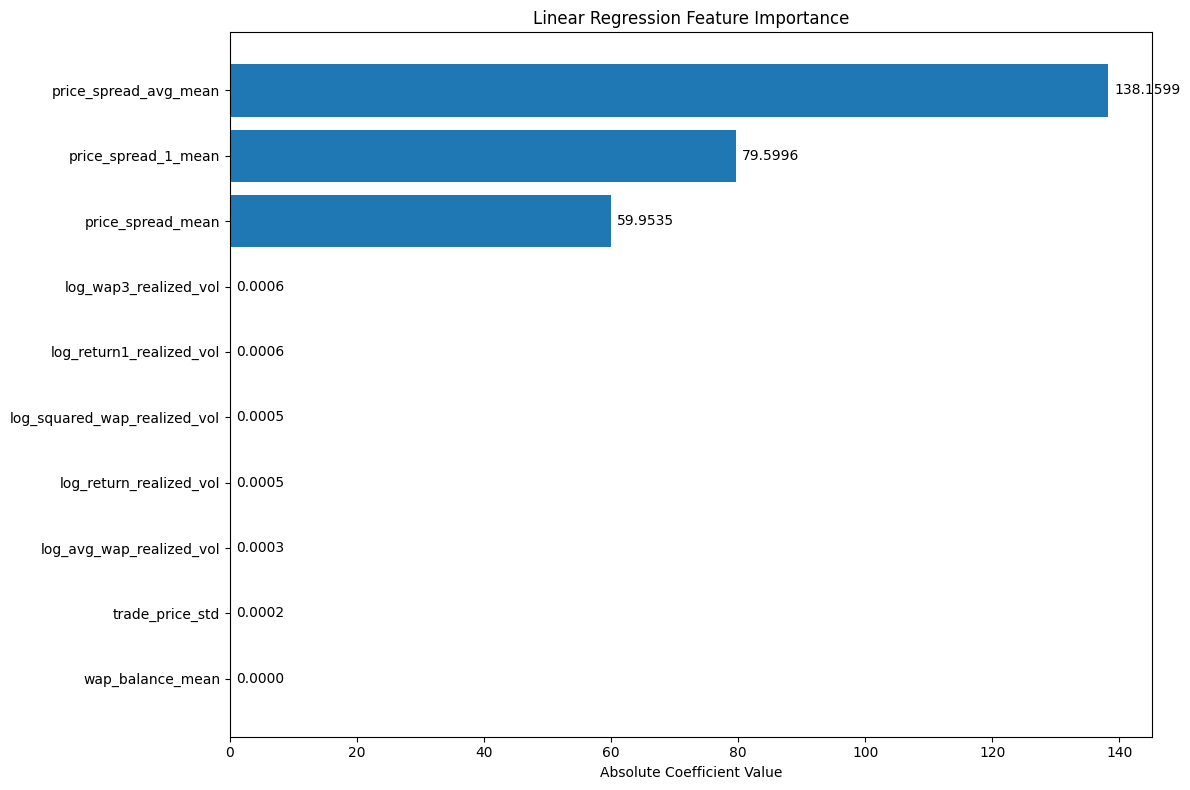

In [69]:
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'], feature_importance['abs_coefficient'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Linear Regression Feature Importance')
plt.gca().invert_yaxis()
for i, v in enumerate(feature_importance['abs_coefficient']):
    plt.text(v + 1, i, f'{v:.4f}', va='center')
plt.tight_layout()
plt.show()

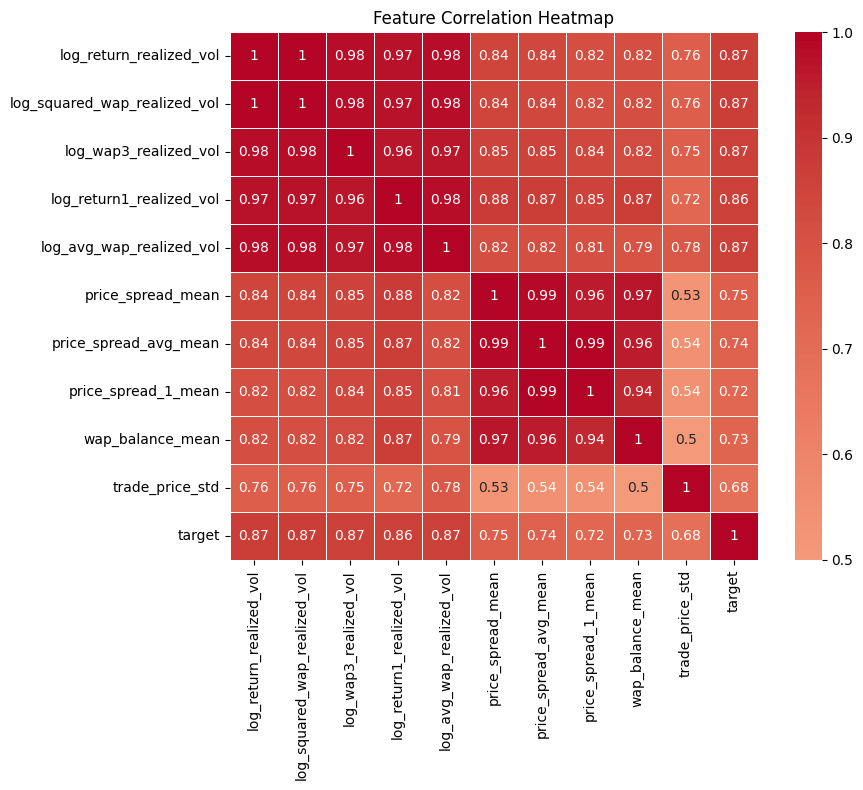

In [70]:
plt.figure(figsize=(10, 8))
correlation_matrix = training_table[top_features + ['target']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [72]:
data_summary = {
    'Dataset Component': [
        'Total Observations', 'Unique Stocks', 'Time Periods', 
        'Training Set', 'Validation Set', 'Features Generated',
        'Top Features Selected', 'Target Range (Min)', 'Target Range (Max)'
    ],
    'Value': [
        428932, 112, 3830, 343144, 85788, 46, 10, 
        f"{train_df['target'].min():.6f}", 
        f"{train_df['target'].max():.6f}"
    ],
    'Notes': [
        'Stock-time combinations', 'Anonymized stock IDs', '10-minute intervals',
        'Chronologically earlier (80%)', 'Chronologically later (20%)', 
        'Engineered from raw data', 'Highest correlations', 
        'Minimum volatility', 'Maximum volatility'
    ]
}

summary_df = pd.DataFrame(data_summary)
print("\nDATASET OVERVIEW")
print("="*50)
display(summary_df)


DATASET OVERVIEW


,Dataset Component,Value,Notes
0,Total Observations,428932,Stock-time combinations
1,Unique Stocks,112,Anonymized stock IDs
2,Time Periods,3830,10-minute intervals
3,Training Set,343144,Chronologically earlier (80%)
4,Validation Set,85788,Chronologically later (20%)
5,Features Generated,46,Engineered from raw data
6,Top Features Selected,10,Highest correlations
7,Target Range (Min),0.000105,Minimum volatility
8,Target Range (Max),0.070321,Maximum volatility


In [ ]:
comparison_data = {
    'Model': ['Linear Regression', 'Random Baseline', 'Mean Baseline'],
    'RMSE': [0.001397, 'N/A', f"{np.std(y):.6f}"],
    'R² Score': [f"{lr_model.score(X_scaled, y):.4f}", '0.0000', '0.0000'],
    'Interpretability': ['High', 'N/A', 'High'],
    'Speed': ['Fast', 'Instant', 'Instant'],
    'Complexity': ['Low', 'None', 'None']
}

comparison_df = pd.DataFrame(comparison_data)
print("\nMODEL COMPARISON")
print("="*40)
display(comparison_df)


⚖️ MODEL COMPARISON


,Model,RMSE,R² Score,Interpretability,Speed,Complexity
0,Linear Regression,0.001397,0.7705,High,Fast,Low
1,Random Baseline,N/A,0.0000,N/A,Instant,None
2,Mean Baseline,0.002975,0.0000,High,Instant,None
